In [1]:
cd /home/al2644/research/codebase/reasoning/perturb-r

/home/al2644/research/codebase/reasoning/perturb-r


/home/al2644/anaconda3/envs/rlvr_eval/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [ ]:
import random
from fractions import Fraction
from typing import List, Tuple
import pandas as pd
from datasets import Dataset

import pandas as pd 
import os 

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import seaborn as sns

from datasets import load_dataset, load_from_disk
import numpy as np
import json

from utils.corrupt_num import *
from utils.chunk_r import *

# Check Eval Dataset

In [7]:
path = "./data/allmath/"
dataset = load_from_disk(path)['test']
eval_df = dataset.to_pandas()

In [8]:
eval_df

,problem,solution,source
0,Every morning Aya goes for a $9$-kilometer-lon...,204,aime24
1,Let $ABC$ be a triangle inscribed in circle $\...,113,aime24
2,Each vertex of a regular octagon is independen...,371,aime24
3,Define $f(x)=|| x|-\tfrac{1}{2}|$ and $g(x)=||...,385,aime24
4,Let $p$ be the least prime number for which th...,110,aime24
...,...,...,...
461,A baseball has diameter $=7.4 \mathrm{~cm}$. a...,\[\n\begin{aligned}\nD_{\text {ball }} &=0.074...,minerva_math
462,Preamble: Consider the Particle in an Infinite...,\[\n\langle E\rangle =\boxed{\frac{1}{3} E_{1}...,minerva_math
463,Preamble: Consider the Particle in an Infinite...,Since the only eigenergies are $E_{1}$ and $E_...,minerva_math
464,Preamble: Evaluate the following integrals for...,\[\n\begin{gathered}\n\int \psi_{22}^{*}\left(...,minerva_math


# Reasoning Benchmark Eval

In [12]:
root = "./results/allmath/benchmark/"
for fname in os.listdir(root):
    if 'model_judge' not in fname:
        print(fname)
        df = pd.read_pickle(os.path.join(root, fname))
        print(f"Accuracy: {df['is_correct'].mean()}")

OpenThinker3-1.5B.pickle
Accuracy: 0.44340128755364805
OpenThinker3-7B.pickle
Accuracy: 0.5718884120171673
DeepScaleR-1.5B-Preview.pickle
Accuracy: 0.44957081545064376
DeepMath-1.5B.pickle
Accuracy: 0.4522532188841202
DeepMath-Zero-7B.pickle
Accuracy: 0.44259656652360513
R1-Distill-Qwen-1.5B.pickle
Accuracy: 0.38680257510729615
R1-Distill-Qwen-7B.pickle
Accuracy: 0.5303111587982833
Qwen3-1.7B.pickle
Accuracy: 0.510461373390558


In [18]:
os.listdir(os.path.join(root, 'model_judge'))

['OpenThinker3-1.5B_model_judge.pickle',
 'OpenThinker3-7B_model_judge.pickle',
 'DeepScaleR-1.5B-Preview_model_judge.pickle']

In [23]:
root = "./results/allmath/benchmark/"
model = 'OpenThinker3-7B'
df=pd.read_pickle(os.path.join(root, f'{model}.pickle'))
mj_df = pd.read_pickle(os.path.join(root, f"model_judge/{model}_model_judge.pickle"))
df = df.merge(mj_df, left_index= True, right_index=True)

### Pass@1 Avg 8

In [20]:
# OpenThinker3-1.5B
df.groupby('source')[["model_is_correct"]].mean()

,model_is_correct
source,
aime24,0.550000
aime25,0.437500
math500,0.850746
minerva_math,0.431985


In [22]:
# DeepScaleR-1.5B-Preview
df.groupby('source')[["model_is_correct"]].mean()

,model_is_correct
source,
aime24,0.408333
aime25,0.300000
math500,0.772388
minerva_math,0.518842


In [24]:
# OpenThinker3-7B
df.groupby('source')[["model_is_correct"]].mean()

,model_is_correct
source,
aime24,0.662500
aime25,0.616667
math500,0.930037
minerva_math,0.625460


### Pass Rate@8

In [334]:
stats = df.groupby('problem').agg({'model_is_correct': 'mean', 'source': 'first'}).reset_index()

In [337]:
stats.groupby('source')[['model_is_correct']].value_counts().to_frame()

count
source       model_is_correct       
aime24       1.000                10
             0.875                 7
             0.000                 5
             0.750                 3
             0.375                 2
             0.625                 2
             0.125                 1
aime25       1.000                 8
             0.000                 7
             0.625                 3
             0.125                 2
             0.250                 2
             0.375                 2
             0.500                 2
             0.750                 2
             0.875                 2
math500      1.000               104
             0.875                11
             0.000                 4
             0.750                 4
             0.375                 3
             0.625                 3
             0.125                 2
             0.250                 2
             0.500                 1
minerva_math 1.000               135
             0.000                57
             0.875                21
             0.125                12
             0.750                12
             0.250                 9
             0.375                 9
             0.500                 9
             0.625                 8

### visualization

In [77]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

root = "./results/deepmath/benchmark/"
steps = [200, 400, 600, 800, 1000, 1200, 1400, 1890]

# template → label (keep keys concise for legends)
templates = {
    "stage0-sft"          : "Qwen2.5-1.5B-DeepMath-level1-4-sft-stage0-step{step}.pickle"
}

# pick linestyles for the three model variants
dashes_map = {"stage0-sft": ""}

In [78]:
def collect_records():
    """Return tidy DataFrame with columns:
       step, model, level, acc, answer_rate
    """
    out = []
    for model, tmpl in templates.items():
        for step in steps:
            path = os.path.join(root, tmpl.format(step=step))
            df   = pd.read_pickle(path)
            g    = groupby_level(df).reset_index()     # cols: level, acc, answer_rate
            g["step"]  = step
            g["model"] = model
            out.append(g)
    return pd.concat(out, ignore_index=True)

tidy        = collect_records()

In [81]:
tidy

,difficulty,correct,step,model
0,3.0,41.0,200,stage0-sft
1,3.5,16.5,200,stage0-sft
2,4.0,18.0,200,stage0-sft
3,4.5,23.0,200,stage0-sft
4,5.0,15.0,200,stage0-sft
...,...,...,...,...
99,7.0,30.0,1890,stage0-sft
100,7.5,28.0,1890,stage0-sft
101,8.0,26.0,1890,stage0-sft
102,8.5,24.0,1890,stage0-sft


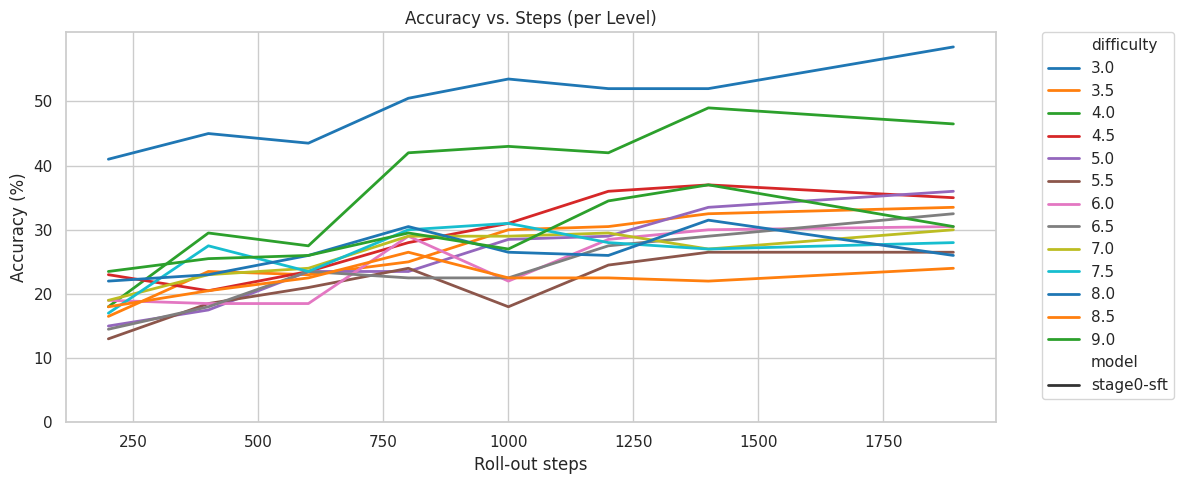

In [79]:

# ------------------------------------------------------------------
# PLOTTING  ---------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.0)

def lineplot(metric, ylabel, title):
    ax = sns.lineplot(
        data   = tidy,
        x      = "step",
        y      = metric,
        hue    = "difficulty",      # color ↔ difficulty level
        style  = "model",      # linestyle ↔ model variant
        dashes = dashes_map,   # enforce our line styles
        palette= "tab10",
        linewidth = 2.0,
    )
    ax.set(
        xlabel = "Roll-out steps",
        ylabel = ylabel,
        title  = title,
    )
#     ax.set_xticks([50, 100, 150, 200, 250])
    ax.set_yticks(range(0, 60, 10)) 
    
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()

plt.figure(figsize=(12,5))
lineplot("correct", "Accuracy (%)", "Accuracy vs. Steps (per Level)")
plt.show()

In [89]:
df

,difficulty,topic,subtopic,problem,solution,task,response,correct,if_answer,token_counts
0,3.0,Mathematics -> Algebra -> Algebra -> Algebraic...,0,Simplify $(2x - 5)(x + 7) - (x + 5)(2x - 1)$.,-30,math,"<think>\nOkay, so I need to simplify this expr...",1.0,True,2251
1,3.0,Mathematics -> Applied Mathematics -> Math Wor...,1,Ten families have an average of 2 children per...,2.5,math,"<think>\nOkay, so I need to figure out the ave...",1.0,True,1396
2,3.0,Mathematics -> Geometry -> Plane Geometry -> T...,5,Andrea notices that the 40-foot tree next to h...,60,math,"<think>\nOkay, so I need to figure out how tal...",1.0,True,1150
3,3.0,Mathematics -> Number Theory -> Prime Numbers,6,Find the sum of the first 9 prime numbers.,100,math,"<think>\nOkay, so I need to find the sum of th...",0.0,True,7256
4,3.0,Mathematics -> Number Theory -> Congruences,6,Find one integer solution to the Diophantine e...,"(3, 1, -1)",math,"<think>\nOkay, so I need to find one integer s...",0.0,False,16383
...,...,...,...,...,...,...,...,...,...,...
2595,9.0,Mathematics -> Discrete Mathematics -> Logic,4,Determine the least cardinality \( \kappa \) s...,\aleph_1,math,"<think>\nOkay, so I need to figure out the lea...",0.0,True,7669
2596,9.0,Mathematics -> Other,7,Identify the name of the smallest ordinal numb...,\omega_1,math,"<think>\nOkay, so I need to figure out the nam...",0.0,True,6695
2597,9.0,Mathematics -> Applied Mathematics -> Statisti...,1,Evaluate the variance of the stochastic integr...,2t^3,math,"<think>\nOkay, so I need to find the variance ...",0.0,True,9810
2598,9.0,Mathematics -> Algebra -> Abstract Algebra -> ...,0,Determine the class group of the complement of...,0,math,"<think>\nOkay, so I need to find the class gro...",0.0,True,3929


In [ ]:
def groupby_level (df):
    stats = df.groupby('level')['correct'].mean()
    answer_rate = df.groupby('level')['if_answer'].mean()
    result = pd.DataFrame({'acc': stats * 100, 'answer_rate': answer_rate * 100})
    return result

### visualization

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

root = "./results/countdown/benchmark/"
steps = [50, 100, 150, 200, 250]

# template → label (keep keys concise for legends)
templates = {
    "stage2"          : "Qwen2.5-3B-countdown-level5-stage2-{step}steps.pickle",
    "stage2-rand-thought"      : "Qwen2.5-3B-countdown-level5-random_thought-stage2-{step}steps.pickle",
    "stage2-rand-thought-only" : "Qwen2.5-3B-countdown-level5-random_thought-only-stage2-{step}steps.pickle",
}

# pick linestyles for the three model variants
dashes_map = {"stage2": "",         # solid
              "stage2-rand-thought": (2,2),  # dotted
              "stage2-rand-thought-only": (4,2)}  # dashed

baseline_files = {
    "sft-stage0"   : "Qwen2.5-3B-distill-countdown-level3-4-1epoch-stage0.pickle",
    "stage1-rl"  : "Qwen2.5-3B-grpo-countdown-level4-5-1epoch-stage1.pickle",
}

# give every *baseline* a distinct (long-dash) line style
dashes_map.update({k: (6,2) for k in baseline_files})   # e.g. – – – –

dashes_map.update({
    "sft-stage0" : (1, 1, 3, 1),   #   ·  — ·   —  (dash–dot)
    "stage1-rl"  : (8, 3, 2, 3),   #   ———   — ———   (long-short-long)
})

# ------------------------------------------------------------------
# 1.  LOAD EVERYTHING INTO ONE TIDY FRAME --------------------------
# ------------------------------------------------------------------
def collect_static(baseline_files):
    """Duplicate each baseline’s per-level metric across *all* steps so
       Seaborn treats them as horizontal lines.
    """
    out = []
    for model, rel_path in baseline_files.items():
        df  = pd.read_pickle(os.path.join(root, rel_path))
        g   = groupby_level(df).reset_index()            # level, acc, answer_rate
        for step in steps:                               # broadcast → every x-pos
            g_step = g.copy()
            g_step["step"]  = step
            g_step["model"] = model
            out.append(g_step)
    return pd.concat(out, ignore_index=True)

tidy_static = collect_static(baseline_files)

def collect_records():
    """Return tidy DataFrame with columns:
       step, model, level, acc, answer_rate
    """
    out = []
    for model, tmpl in templates.items():
        for step in steps:
            path = os.path.join(root, tmpl.format(step=step))
            df   = pd.read_pickle(path)
            g    = groupby_level(df).reset_index()     # cols: level, acc, answer_rate
            g["step"]  = step
            g["model"] = model
            out.append(g)
    return pd.concat(out, ignore_index=True)

tidy        = collect_records()
tidy_static = collect_static(baseline_files)
tidy        = pd.concat([tidy, tidy_static], ignore_index=True)   # ← merge


# ------------------------------------------------------------------
# PLOTTING  ---------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.0)

def lineplot(metric, ylabel, title):
    ax = sns.lineplot(
        data   = tidy,
        x      = "step",
        y      = metric,
        hue    = "level",      # color ↔ difficulty level
        style  = "model",      # linestyle ↔ model variant
        dashes = dashes_map,   # enforce our line styles
        palette= "tab10",
        linewidth = 2.0,
    )
    ax.set(
        xlabel = "Roll-out steps",
        ylabel = ylabel,
        title  = title,
    )
    ax.set_xticks([50, 100, 150, 200, 250])
    ax.set_yticks(range(0, 101, 10)) 
    
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()

plt.figure(figsize=(12,5))
lineplot("acc", "Accuracy (%)", "Accuracy vs. Steps (per Level)")
plt.show()

In [92]:
acc = tidy[tidy['difficulty'].isin([7., 8.])]
acc

,difficulty,correct,step,model
8,7.0,19.0,200,stage0-sft
10,8.0,22.0,200,stage0-sft
21,7.0,23.0,400,stage0-sft
23,8.0,23.0,400,stage0-sft
34,7.0,24.0,600,stage0-sft
36,8.0,26.0,600,stage0-sft
47,7.0,29.0,800,stage0-sft
49,8.0,30.5,800,stage0-sft
60,7.0,29.0,1000,stage0-sft
62,8.0,26.5,1000,stage0-sft


# Corrupted Numbers

In [840]:
pwd

'/home/al2644/research/codebase/reasoning/perturb-r'

In [841]:
root = "./results/countdown/corrupt_numbers/"

def has_answer (response):
    if "<answer>" in response:
        return 1.
    else:
        return 0.
    
for fname in os.listdir(root):
    if 'still_correct' not in fname:
        print(fname)
        df = pd.read_pickle(os.path.join(root, fname))
        print(f"Accuracy: {df['still_correct'].mean()}")

Qwen2.5-3B-distill-countdown-level3-4-1epoch.pickle
Accuracy: 0.5202702702702703
Qwen2.5-3B-grpo-countdown-level4-5-1epoch.pickle
Accuracy: 0.5934684684684685


In [842]:
df = pd.read_pickle(os.path.join(root, "Qwen2.5-3B-grpo-countdown-level4-5-1epoch.pickle"))


In [844]:
df.groupby("start_pos")["still_correct"].mean()

start_pos
0.00    0.184685
0.25    0.720721
0.50    0.752252
0.75    0.716216
Name: still_correct, dtype: float64

In [854]:
df.groupby("start_pos")["if_answer"].mean()

start_pos
0.00    0.409910
0.25    0.765766
0.50    0.788288
0.75    0.995495
Name: if_answer, dtype: float64

In [858]:
example = df[(df["start_pos"] == 0.5) & (df["still_correct"] == 0.) & (df["if_answer"] == True)].iloc[0]

In [859]:
print(example["prompt"])

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Please reason and answer the following question. Using the numbers [13, 10, 27, 92, 31], create an equation that equals 742. You can only use basic arithmetic operations (+, -, *, /) in the expression and each number should be used exactly once. You should report the answer equation expression in <answer> </answer> tags, for example <answer> (1 + 2) / 3 </answer>.<|im_end|>
<|im_start|>assistant
<think>


Okay, let's see. I need to use the numbers 13, 10, 27, 92, and 31 exactly once each, with basic operations to make 742. Hmm. Let me think. First, maybe I should try combining some numbers to get closer to 742. Since 742 is a relatively large number, maybe multiplication is involved here. Let me check the numbers: 92 is


the largest, then 31, 27, 10, 13.


Let me think about possible multiplications. If I multiply 92 by something, maybe? Let's see. 92 * 8 is 736, which is close to 742. But how do I get 8 from t

In [860]:
print(example["post_corruption_response"])

 

Alternatively, think of 92 * 10 = 920. Then 920 - 27 = 893. 893 - 13 = 880. 880 + 31 = 911. No, that's not helpful. 

Alternatively, 92 * 27 = 2484. Then 2484 - 31 = 2453. 2453 - 13 = 2440. 2440 + 10 = 2450. Not 742. 

Alternatively, 92 * 13 = 1204. Then 1204 - 31 = 1173. 1173 - 27 = 1146. 1146 - 10 = 1136. That's way over. 

Alternatively, 92 * 31 = 2852. Then 2852 - 27 = 2825. 2825 - 13 = 2812. 2812 - 10 = 2802. No. 

Alternatively, 31 * 10 = 310. Then 310 + 27 = 337. 337 + 92 = 429. 429 + 13 = 442. No. 

Wait, maybe 27 * 13 = 351. Then 351 * 2 = 702. Then 702 + 40 = 742. How to get 40 from 92 and 31. 92 - 31 = 61. Not 40. 92 - 31 is 61, then 61 - 10 = 51. No. 

Alternatively, 27 * 10 = 270. Then 270 + 92 = 362. 362 * something? 362 * 2 is 724. Then 724 + 18 = 742. How to get 18 from 13 and 31. 31 - 13 = 18. Oh! Wait! That's possible. 

So let's see: (27 * 10) + 92 = 362. Then 362 + (31 - 13) = 362 + 18 = 380. No, that's not. Wait, but if I do 27 * 10 + 92 + (31 -13) = 362 + 92 + 

In [695]:
wrong_answer[['level', 'type']].value_counts()

level  type         
5      post_</think>    80
6      post_</think>    21
5      pre_</think>     17
6      pre_</think>      5
Name: count, dtype: int64

# Distractor Injection

In [796]:
root = "./results/countdown/inject_distractor/"

def has_answer (response):
    if "<answer>" in response:
        return 1.
    else:
        return 0.
    
for fname in os.listdir(root):
    print(fname)
    df = pd.read_pickle(os.path.join(root, fname))
    print(f"Original Accuracy: {df['original_correct'].mean()}")
    print(f"Distractor Accuracy: {df['distractor_correct'].mean()}")

df = pd.read_pickle(os.path.join(root, "Qwen2.5-3B-grpo-countdown-level4-5-1epoch.pickle"))

Qwen2.5-3B-distill-countdown-level3-4-1epoch.pickle
Original Accuracy: 0.3626237623762376
Distractor Accuracy: 0.5006188118811881
Qwen2.5-3B-grpo-countdown-level4-5-1epoch.pickle
Original Accuracy: 0.46163366336633666
Distractor Accuracy: 0.47277227722772275


In [797]:
df = pd.read_pickle(os.path.join(root, "Qwen2.5-3B-distill-countdown-level3-4-1epoch.pickle"))
df.groupby("prefix_ratio")[["original_correct", "distractor_correct"]].mean()

,original_correct,distractor_correct
prefix_ratio,,
0.00,0.047030,0.816832
0.25,0.544554,0.292079
0.50,0.462871,0.400990
0.75,0.396040,0.492574


In [798]:
df = pd.read_pickle(os.path.join(root, "Qwen2.5-3B-grpo-countdown-level4-5-1epoch.pickle"))
df.groupby("prefix_ratio")[["original_correct", "distractor_correct"]].mean()

,original_correct,distractor_correct
prefix_ratio,,
0.00,0.009901,0.938119
0.25,0.670792,0.252475
0.50,0.613861,0.309406
0.75,0.551980,0.391089


In [799]:
df

,nums,target,example_solution,problem,level,task,original_response,reasoning_chunks,prefix_ratio,distractor_ratio,distract_nums,distract_target,distract_reasoning,prompt,post_distraction_response,original_correct,distractor_correct
0,"[50, 77, 64, 67, 73]",331,(((73+50)+64)+(67+77)),Please reason and answer the following questio...,5,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.0,0.25,"[86, 91, 87, 68, 77, 66]",165,"<think>\nOkay, let's see. I need to use the nu...",<|im_start|>system\nYou are a helpful assistan...,"Not sure. Alternatively, 87 - 66 = 21. 91 - 7...",0.0,1.0
1,"[50, 77, 64, 67, 73]",331,(((73+50)+64)+(67+77)),Please reason and answer the following questio...,5,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.0,0.5,"[20, 73, 85, 82, 33]",89,"<think>\nOkay, let's see. I need to use the nu...",<|im_start|>system\nYou are a helpful assistan...,33 + 85 is 118. 118 - 82 is 36. 36 +73 is 109...,0.0,1.0
2,"[50, 77, 64, 67, 73]",331,(((73+50)+64)+(67+77)),Please reason and answer the following questio...,5,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.0,0.75,"[20, 73, 85, 82, 33]",89,"<think>\nOkay, let's see. I need to use the nu...",<|im_start|>system\nYou are a helpful assistan...,So the answer would be that expression. So th...,0.0,1.0
3,"[50, 77, 64, 67, 73]",331,(((73+50)+64)+(67+77)),Please reason and answer the following questio...,5,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.0,1.0,"[74, 51, 64, 31, 48]",104,"<think>\nOkay, let's see. I need to use the nu...",<|im_start|>system\nYou are a helpful assistan...,The answer should be in <answer> tags. So <an...,0.0,1.0
4,"[50, 77, 64, 67, 73]",331,(((73+50)+64)+(67+77)),Please reason and answer the following questio...,5,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.25,0.25,"[25, 87, 42, 34, 57]",63,"<think>\nOkay, let's see. I need to use each o...",<|im_start|>system\nYou are a helpful assistan...,"87 - 57 is 30, then 30 - 25 is 5, not helpful....",1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,"[84, 3, 85, 12, 51, 9]",307,(((9+85)+12)+((3*84)-51)),Please reason and answer the following questio...,6,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.5,1.0,"[75, 96, 96, 56, 68]",129,"<think>\nOkay, let's see. I need to use each o...",<|im_start|>system\nYou are a helpful assistan...,"Therefore, the equation is 96 - 75 + 96 + 68 ...",1.0,0.0
1612,"[84, 3, 85, 12, 51, 9]",307,(((9+85)+12)+((3*84)-51)),Please reason and answer the following questio...,6,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.75,0.25,"[74, 51, 64, 31, 48]",104,"<think>\nOkay, let's see. I need to use each o...",<|im_start|>system\nYou are a helpful assistan...,Maybe (64 - 51) = 13. Then 13 + 48 = 61. Then...,1.0,0.0
1613,"[84, 3, 85, 12, 51, 9]",307,(((9+85)+12)+((3*84)-51)),Please reason and answer the following questio...,6,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.75,0.5,"[71, 93, 76, 10, 96]",184,"<think>\nOkay, let's see. I need to use each o...",<|im_start|>system\nYou are a helpful assistan...,204 is not 184. What if I do 76 + 93 = 169. 16...,0.0,0.0
1614,"[84, 3, 85, 12, 51, 9]",307,(((9+85)+12)+((3*84)-51)),Please reason and answer the following questio...,6,countdown,"<think>\nOkay, let's see. I need to use each o...","[<think>\nOkay, let's see. I need to use each ...",0.75,0.75,"[17, 76, 59, 23, 18]",41,"<think>\nOkay, let's see. I need to use each o...",<|im_start|>system\nYou are a helpful assistan

In [802]:
idx = 7
example = df.iloc[idx]
prefix_ratio, distractor_ratio = example["prefix_ratio"], example["distractor_ratio"]
print("prefix_ratio: ", prefix_ratio)
print("distractor_ratio: ", distractor_ratio)
prompt, response, original_correct, distractor_correct = example["prompt"], example["post_distraction_response"], example["original_correct"], example["distractor_correct"]

print("original correct?: ", original_correct)
print("distract correct?: ", distractor_correct)

prefix_ratio:  0.25
distractor_ratio:  1.0
original correct?:  0.0
distract correct?:  1.0


In [803]:
print(prompt)

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
Please reason and answer the following question. Using the numbers [50, 77, 64, 67, 73], create an equation that equals 331. You can only use basic arithmetic operations (+, -, *, /) in the expression and each number should be used exactly once. You should report the answer equation expression in <answer> </answer> tags, for example <answer> (1 + 2) / 3 </answer>.<|im_end|>
<|im_start|>assistant
<think>
Okay, let's see. I need to use each of the numbers 50, 77, 64, 67, and 73 exactly once with basic operations to make 331. Hmm. Let me think about possible combinations.Wait. Let me think again: Okay, let's see. I need to use the numbers 86, 91, 87, 68, 77, and 66 exactly once each, with basic arithmetic operations to make 165. Hmm, first, maybe I should think about possible combinations. Let me list the numbers again: 86, 91, 87, 68, 77, 66. All have to be used once. The target is 165.What's 165? Let me think abo

In [804]:
print(response)

 Which is the same as the previous grouping. Alternatively, written as (66 + 77) + (86 - 68) + (91 - 87). Either way, the operations are all allowed. Let me check again if the order is correct. Let me compute the expression step by step. 66 + 77 is 143. Then 143 + 86 is 229. Then subtract 68: 229 - 68 = 161. Then add 91: 161 + 91 = 252. Then subtract 87: 252 - 87 = 165. Correct. So that's the right equation.
</think>

<answer> 66 + 77 + 86 - 68 + 91 - 87 </answer>



In [ ]:
evals
    0. same set of stress tests for both math and countdown
    1. if observations on countdown and math are consistent
    2. if the corruption happens in the first chunk
    3. check the eval results for sft 3 epoch

In [ ]:
training todo:
    
    mix original question and corrupted prefix
    1. collect offline rl prefix ==> rl (save checkpoints for later eval)
    2. rl on same flops ==> same number of problems (assuming problems i.i.d)
    3. 1st rl collect for rejection sampling
    
    
generalization:
    1. different types of corruption (distractor injection, just wrong answer at the end)
    2. different degrees of digit corruption
    3. different task complexity
    


In [ ]:
generate more level 5, 6, 7 questions 50K each
use r1 to generate corrupted prefix + collect recovery + not recover (50 50)

we can launch 2 first

# Check test set

In [42]:
df1 = pd.read_parquet("../rlvr/data/train/countdown_level5_random_thought_30k/test.parquet")
df2 = pd.read_parquet("../rlvr/data/train/countdown_level5_random_thought_only_15k/test.parquet")

In [43]:
df1

,data_source,prompt,ability,reward_model,extra_info
0,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [50, 77, 64, 67, ...","{'index': 0, 'level': '6', 'split': 'test'}"
1,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [88, 84, 11, 71, ...","{'index': 1, 'level': '6', 'split': 'test'}"
2,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [35, 48, 94, 46, ...","{'index': 2, 'level': '6', 'split': 'test'}"
3,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [18, 58, 64, 42, ...","{'index': 3, 'level': '6', 'split': 'test'}"
4,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [37, 18, 51, 39, ...","{'index': 4, 'level': '6', 'split': 'test'}"
...,...,...,...,...,...
295,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [95, 38, 13, 72, ...","{'index': 295, 'level': '7', 'split': 'test'}"
296,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [51, 100, 99, 91,...","{'index': 296, 'level': '7', 'split': 'test'}"
297,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [44, 2, 3, 41, 85...","{'index': 297, 'level': '7', 'split': 'test'}"
298,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [55, 20, 64, 3, 4...","{'index': 298, 'level': '7', 'split': 'test'}"


In [44]:
df2

,data_source,prompt,ability,reward_model,extra_info
0,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [50, 77, 64, 67, ...","{'index': 0, 'level': '6', 'split': 'test'}"
1,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [88, 84, 11, 71, ...","{'index': 1, 'level': '6', 'split': 'test'}"
2,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [35, 48, 94, 46, ...","{'index': 2, 'level': '6', 'split': 'test'}"
3,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [18, 58, 64, 42, ...","{'index': 3, 'level': '6', 'split': 'test'}"
4,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [37, 18, 51, 39, ...","{'index': 4, 'level': '6', 'split': 'test'}"
...,...,...,...,...,...
295,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [95, 38, 13, 72, ...","{'index': 295, 'level': '7', 'split': 'test'}"
296,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [51, 100, 99, 91,...","{'index': 296, 'level': '7', 'split': 'test'}"
297,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [44, 2, 3, 41, 85...","{'index': 297, 'level': '7', 'split': 'test'}"
298,countdown,[{'content': 'Please reason and answer the fol...,math,"{'ground_truth': {'numbers': [55, 20, 64, 3, 4...","{'index': 298, 'level': '7', 'split': 'test'}"
